### Loading Packages

In [1]:
# Reading and pre-processing
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Plotting
import matplotlib.pyplot as plt
import scikitplot

# Modeling CNN
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from keras.optimizers import adam
from keras.losses import categorical_crossentropy
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

# Showing model results
from sklearn.metrics import classification_report

# Loading model in a JSON file
from keras.models import model_from_json

### Reading data

In [2]:
df = pd.read_csv("data/icml_face_data.csv")

### EDA

In [ ]:
df.shape

Removing spaces in column names.

In [3]:
df.columns = df.columns.str.replace(' ', '')

Making emotions relatable.

In [4]:
emotion_label = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
df['emotion_label'] = df['emotion'].map(emotion_label)

In [ ]:
df.emotion_label.value_counts().sort_values()

* Most of our data has happy emotions. 
* Across other emotions it's generally balanced, however happiness does make up a quarter of all the images, whereas the "disgust" being in minority, with around 1.5%.

In [ ]:
df.groupby(["Usage", "emotion"]).count()

Also no big differences in balance across test and training data.

Before we continue, let's bear in mind that human emotions can be hard to identified even by humans, as they usually encompass a range of subtle differences in the face. The combination of the mouth, eyebrows, eyes, cheek movement, etc can mean the difference between sadness and happiness.  

According to https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4873105/#:~:text=The%20emotions%20better%20recognized%20from,were%20more%20difficult%20to%20recognize, the hardest recognizable emotions are surprise, neutral and sadness.

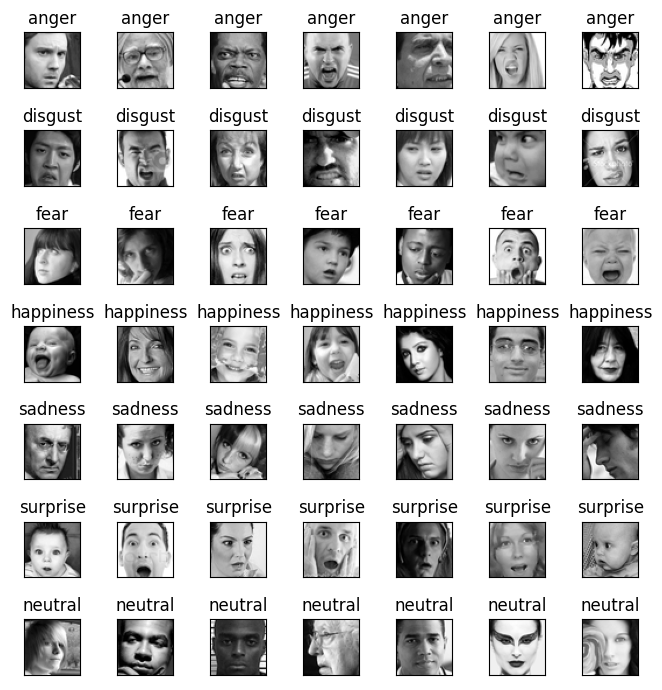

In [8]:
fig = plt.figure(1, (13, 13))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion == label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_title(emotion_label[label])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.tight_layout()

* We've got baby and adult images, including character images.
* The faces are not only upright, but we can see instances where it's from the side or when they are covered. Probably the latest emotions would be harder to identify.
* Also, some images are labeled as "happy" that I would doubt that they are "happy".
* We are dealing with low-resolution pictures, which means we cannot expect a high level of accuracy.

### Pre-processing data

First, for the model, consider only the anger - 0, happy - 3, sad - 4 emotions.

In [ ]:
model_labels = [0, 3, 4]
df = df[df.emotion.isin(model_labels)] 

In [ ]:
def preprocess_data(df):
    img_array = np.zeros(shape = (len(df), 48, 48))
    img_label = np.array(list(map(int, df['emotion'])))
    
    for i, row in enumerate(df.index):
        img = np.fromstring(df.loc[row, 'pixels'], dtype = int, sep = ' ')
        img = np.reshape(img, (48, 48))
        img_array[i] = img
    return img_array, img_label

img_array_train, img_label_train = preprocess_data(df[df['Usage'] == 'Training'])
img_array_val, img_label_val = preprocess_data(df[df['Usage'] == 'PrivateTest'])
img_array_test, img_label_test = preprocess_data(df[df['Usage'] == 'PublicTest'])

Reshape the data into (batch_size, height, width, channels) for training neural networks with Keras.

In [ ]:
x_train = img_array_train.reshape((img_array_train.shape[0], 48, 48, 1))
x_test = img_array_test.reshape((img_array_test.shape[0], 48, 48, 1))
x_val = img_array_val.reshape((img_array_val.shape[0], 48, 48, 1))

One-hot encode ...

In [ ]:
le = LabelEncoder()
img_label_train = le.fit_transform(img_label_train)
img_label_test = le.fit_transform(img_label_test)
img_label_val = le.fit_transform(img_label_val)

y_train = to_categorical(img_label_train)
y_test = to_categorical(img_label_test)
y_val = to_categorical(img_label_val)

Normalize the images to a [0,1] range ...

In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_val = x_val.astype('float32') / 255

Finally, making sure everything looks consistent.

In [ ]:
x_train.shape, y_train.shape,x_val.shape,y_val.shape, x_test.shape, y_test.shape

### CNN Model Building

In [ ]:
model = Sequential([
    # The images have low resolution therefore I use a small patch of 3,3.
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (48, 48, 1)),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation = 'relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation = 'relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(64, activation = 'relu'),
    BatchNormalization(),
    # We have 3 emotions, therefore 3 possible values in the output.
    Dense(3, activation = 'softmax')
])

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy', 
              metrics = 'accuracy')

model.summary()

Include callbacks to avoid overfitting ...

In [ ]:
stop = EarlyStopping(monitor = 'val_accuracy', patience = 3, verbose = 1, restore_best_weights = True)

... and for reducing the learning rate.

In [ ]:
lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3, verbose = 1, min_lr = 0.0001)


And augment just a bit the data.

In [ ]:
data_gen = ImageDataGenerator(horizontal_flip = True)

In [ ]:
data_gen.fit(x_train)

history = model.fit(data_gen.flow(x_train, y_train),
                    validation_data = (x_val, y_val),
                    epochs = 20,
                    batch_size = 32,
                    callbacks = [stop, lr])

### Model Results

Reaches 76% accuracy

In [ ]:
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc = 'upper right')
plt.show()

plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.legend(loc = 'upper right')
plt.show()

### Predictions

In [ ]:
predictions = model.predict(x_test, use_multiprocessing = True)
acc_fc_orig = np.sum(np.argmax(y_test,axis=1) == np.argmax(predictions,axis=1)) / len(predictions)
print("Acc_fc_orig = " , acc_fc_orig)

In [ ]:
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(predictions, axis = 1), figsize=(7,7))
plt.show()

There is a higher amount of False Positives for sad and angry emotions.

In [ ]:
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(predictions, axis = 1)))


Lowest precision is for the "angry" faces. Let's see now side by side the predictions versus the "true" emotions.

Choosing happy and sad images.

In [ ]:
np.random.seed(2)
happy_imgs = np.random.choice(np.where(y_test[:, 1] == 1)[0], size = 7)
sad_imgs = np.random.choice(np.where(y_test[:, 2] == 1)[0], size = 7)

In [ ]:
fig = plt.figure(1, (12, 6))

mapper = {
    0: "angry",
    1: "happy",
    2: "sad"
}

for i, (happy, sad) in enumerate(zip(happy_imgs, sad_imgs)):
        ax = plt.subplot(2, 7, i + 1)
        sample_img = x_train[happy,:,:,0]
        ax.imshow(sample_img, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"T:happy, P:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1)))]}")
        
        ax = plt.subplot(2, 7, i + 8)
        sample_img = x_train[sad,:,:,0]
        ax.imshow(sample_img, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"T:sad, P:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1)))]}")
        
        plt.tight_layout()

plt.show()

We can see again that some emotions are labeled as happy but looks as sad from a human eye.
Our model seems to predict correctly for the wrongly labeled images.

### Saving model

Save the model to a JSON file.

In [ ]:
json_model = model.to_json()

Save the model architecture to the JSON file.

In [ ]:
with open('fer.json', 'w') as json_file:
    json_file.write(json_model)

Read the model architecture from JSON file.

In [ ]:
with open('fer.json', 'r') as json_file:
    JSON_saved_model = json_file.read()

Save the weights of the model.

In [ ]:
model.save_weights('fer.h5')

Finally, model loss and accuracy.

In [ ]:
loss,acc = model.evaluate(x_test,  y_test, verbose = 2)